# Image reconstruction with spiral trajectory

Copyright 2023 Physikalisch-Technische Bundesanstalt

Licensed under the Apache License, Version 2.0 (the "License");
  you may not use this file except in compliance with the License.
  You may obtain a copy of the License at
      http://www.apache.org/licenses/LICENSE-2.0
  Unless required by applicable law or agreed to in writing, software
  distributed under the License is distributed on an "AS IS" BASIS,
  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
  See the License for the specific language governing permissions and
  limitations under the License.

If you want to run this notebook in binder you need to still install the MRpro package.
This only needs to be done once in a binder session. Open a terminal (File -> New -> Terminal) and run:
```
pip install -e ".[notebook]"
```
This will install the MRpro package. Any other required python packages should already be present in this
docker image.

In [1]:
# Imports
import shutil
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import zenodo_get
from mrpro.data import CsmData
from mrpro.data import DcfData
from mrpro.data import IData
from mrpro.data import KData
from mrpro.data.traj_calculators import KTrajectoryIsmrmrd
from mrpro.data.traj_calculators._KTrajectoryPulseq import KTrajectoryPulseq
from mrpro.operators import FourierOp
from mrpro.operators import SensitivityOp

/opt/conda/envs/RecoEnv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Download raw data in ISMRMRD format from zenodo into a temporary directory
data_folder = Path("/echo/_allgemein/projects/8_13/MRPro/2024_03_19/20240319_spiral_2D_256mm_252k0_256interleaves_golden_angle")#Path(tempfile.mkdtemp())
dataset_traj = 'spiral_2D_256mm_252k0_256interleaves_golden_angle_with_traj.h5'
#zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries

## Image reconstruction
Image reconstruction involves the following steps:
- Reading in the raw data and the trajectory from the ismrmrd raw data file
- Calculating the density compensation function (dcf)
- Reconstructing one image averaging over the entire relaxation period

In [8]:
# Read raw data and trajectory
kdata = KData.from_file(
    filename=data_folder+dataset_traj,
    ktrajectory=KTrajectoryIsmrmrd()
)

# Calculate dcf
dcf = DcfData.from_traj_voronoi(kdata.traj)

# Reconstruct average image for coil map estimation
fourier_op = FourierOp(
    recon_matrix=kdata.header.recon_matrix, encoding_matrix=kdata.header.encoding_matrix, traj=kdata.traj
)

(img,) = fourier_op.adjoint(kdata.data * dcf.data[:, None, ...])

ValueError: Extension for the given ID - 1.0 - is unknown.

In [4]:
# Calculate coilmaps
idata = IData.from_tensor_and_kheader(img, kdata.header)
csm = CsmData.from_idata_walsh(idata)
csm_op = SensitivityOp(csm)

In [5]:
# Coil combination
(img,) = csm_op.adjoint(img)

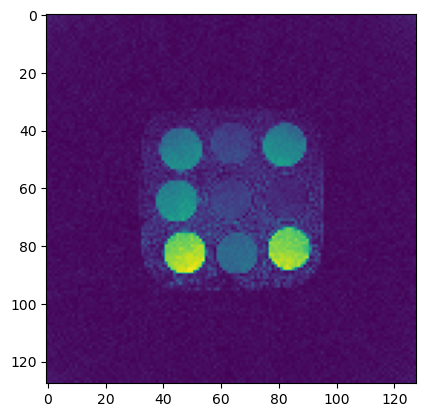

In [6]:
# Visualize results
plt.figure()
plt.imshow(torch.abs(img[0, 0, 0, :, :]))

In [7]:
# Clean-up by removing temporary directory
#shutil.rmtree(data_folder)